## Tutorial of subspace interventions

In [1]:
__author__ = "Zhengxuan Wu"
__version__ = "11/28/2023"

### Overview

Subspace of the basis may be used to represent different orthogonal causal variables. In other words, each column or each partition of columns may be used to represent different high-level causal model. In this tutorial, we want to illustrate how to setup the intervenable to do this.

We introduce a new concept of **subspace** intervention. For the intervention, you can specify if you only want to intervene on a subspace rather than the fullspace.

Then, you can intervene on different subspaces given your examples in a batch, and test for different counterfactual behaviors. Accordingly, you can also train different subspaces to target different counterfactual behaviors using DAS.

### Set-up

In [2]:
try:
    # This library is our indicator that the required installs
    # need to be done.
    import transformers
    import sys
    sys.path.append("align-transformers/")
except ModuleNotFoundError:
    !git clone https://github.com/frankaging/align-transformers.git
    !pip install -r align-transformers/requirements.txt
    import sys
    sys.path.append("align-transformers/")

In [3]:
import sys
sys.path.append("../..")

import pandas as pd
from models.basic_utils import embed_to_distrib, top_vals, format_token
from models.configuration_intervenable_model import IntervenableRepresentationConfig, IntervenableConfig
from models.intervenable_base import IntervenableModel
from models.interventions import RotatedSpaceIntervention
from models.gpt2.modelings_intervenable_gpt2 import create_gpt2

%config InlineBackend.figure_formats = ['svg']
from plotnine import ggplot, geom_tile, aes, facet_wrap, theme, element_text, \
                     geom_bar, geom_hline, scale_y_log10
config, tokenizer, gpt = create_gpt2(cache_dir="../../../.huggingface_cache")

[2024-01-10 11:12:19,678] [INFO] [real_accelerator.py:158:get_accelerator] Setting ds_accelerator to cuda (auto detect)
loaded model


### Subspace alignment config
You just need to specify your intial subspace partition in the config.

Currently, only DAS-related interventions are supporting this. But the concept of subspace intervention can be extended to other types of interventions as well (e.g., vanilla intervention where swapping a subset of activations).

In [4]:
def simple_subspace_position_config(
    model_type, intervention_type, layer, 
    subspace_partition=[[0,384], [384,768]]
):
    intervenable_config = IntervenableConfig(
        intervenable_model_type=model_type,
        intervenable_representations=[
            IntervenableRepresentationConfig(
                layer,                                # layer
                intervention_type,                    # repr intervention type
                "pos",                                # intervention unit
                1,                                    # max number of unit
                subspace_partition=subspace_partition # subspace parition with dimension indices
            )
        ],
        intervenable_interventions_type=RotatedSpaceIntervention,
    )
    return intervenable_config

base = tokenizer("The capital of Spain is", return_tensors="pt")
sources = [tokenizer("The capital of Italy is", return_tensors="pt")]

### Patch Patching on the First Subspace of Position-aligned Tokens
We path patch on the subspace (indexing from 0 to 384) of two modules on each layer:
- [1] MLP output (the MLP output will be from another example)
- [2] MHA input (the self-attention module input will be from another module)

In [5]:
# should finish within 1 min with a standard 12G GPU
tokens = tokenizer.encode(" Madrid Rome")

data = []
for layer_i in range(gpt.config.n_layer):
    intervenable_config = simple_subspace_position_config(type(gpt), "mlp_output", layer_i)
    intervenable = IntervenableModel(intervenable_config, gpt)
    for k, v in intervenable.interventions.items():
        v[0].set_interchange_dim(768)
    for pos_i in range(len(base.input_ids[0])):
        _, counterfactual_outputs = intervenable(
            base,
            sources,
            {"sources->base": ([[[pos_i]]], [[[pos_i]]])},
            subspaces=[[[0]]]
        )
        distrib = embed_to_distrib(
            gpt, counterfactual_outputs.last_hidden_state, 
            logits=False
        )
        for token in tokens:
            data.append({
                'token': format_token(tokenizer, token),
                'prob': float(distrib[0][-1][token]),
                'layer': f"f{layer_i}",
                'pos': pos_i,
                'type': "mlp_output"
            })
            
    intervenable_config = simple_subspace_position_config(type(gpt), "attention_input", layer_i)
    intervenable = IntervenableModel(intervenable_config, gpt)
    for k, v in intervenable.interventions.items():
        v[0].set_interchange_dim(768)
    for pos_i in range(len(base.input_ids[0])):
        _, counterfactual_outputs = intervenable(
            base,
            sources,
            {"sources->base": ([[[pos_i]]], [[[pos_i]]])},
            subspaces=[[[0]]]
        )
        distrib = embed_to_distrib(
            gpt, counterfactual_outputs.last_hidden_state, 
            logits=False
        )
        for token in tokens:
            data.append({
                'token': format_token(tokenizer, token),
                'prob': float(distrib[0][-1][token]),
                'layer': f"a{layer_i}",
                'pos': pos_i,
                'type': "attention_input"
            })
df = pd.DataFrame(data)

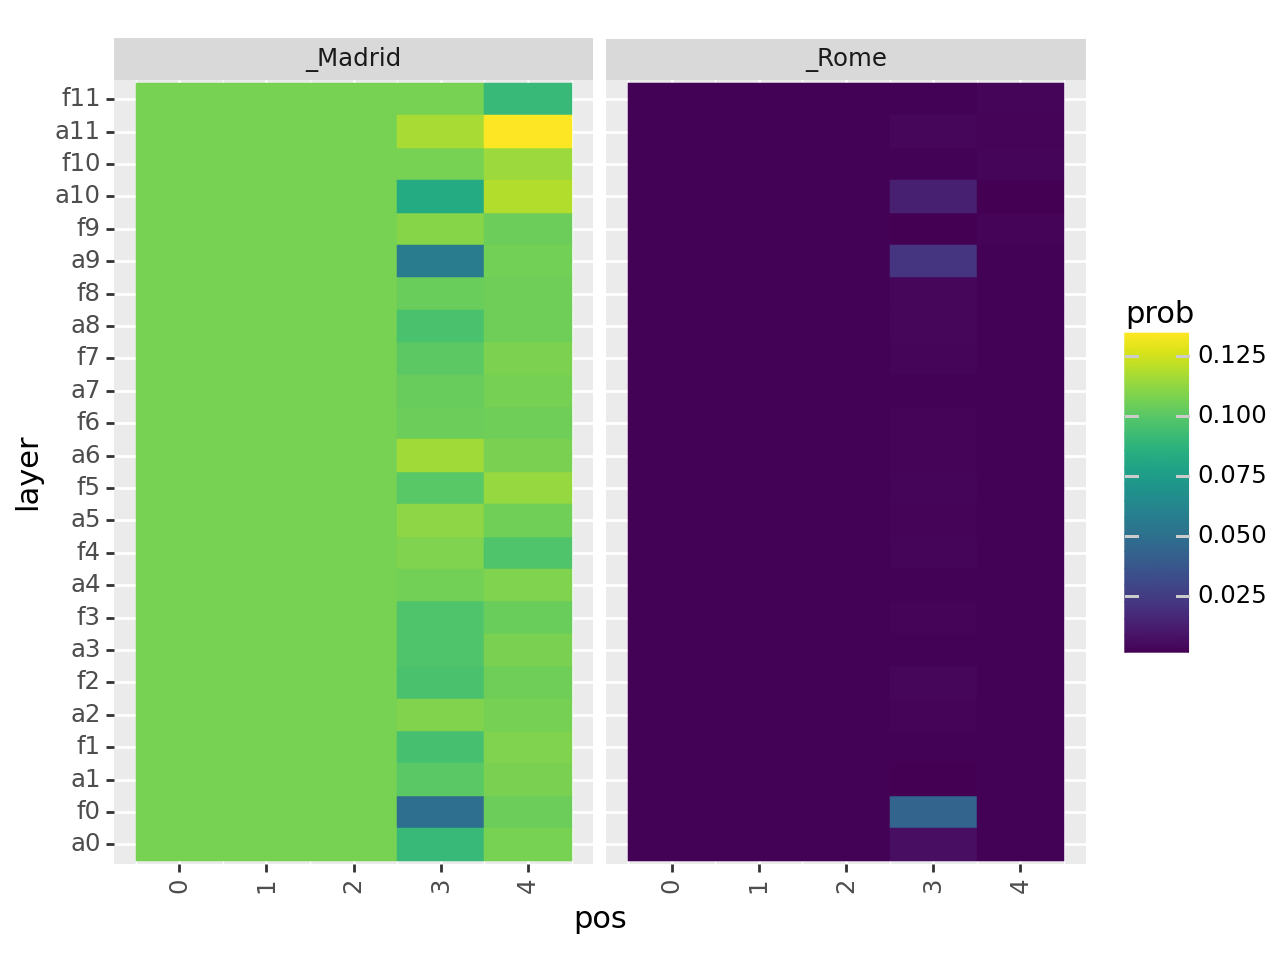

In [7]:
df['layer'] = df['layer'].astype('category')
df['token'] = df['token'].astype('category')
nodes = []
for l in range(gpt.config.n_layer - 1, -1, -1):
    nodes.append(f'f{l}')
    nodes.append(f'a{l}')
df['layer'] = pd.Categorical(df['layer'], categories=nodes[::-1], ordered=True)

g = (ggplot(df) + geom_tile(aes(x='pos', y='layer', fill='prob', color='prob')) +
     facet_wrap("~token") + theme(axis_text_x=element_text(rotation=90)))
print(g)